# Airbnb Price Prediction: Advanced Regression Pipeline

This notebook presents a fully upgraded, production-style machine learning pipeline designed to predict Airbnb listing prices with high accuracy. Compared to the original version, this enhanced workflow introduces stronger data preprocessing, domain-specific feature engineering, robust outlier handling, and modern gradient-boosting models that significantly improve predictive performance.

## Overview

Airbnb pricing is a complex problem influenced by diverse factors: property capacity, host experience, listing quality, neighbourhood characteristics, seasonal demand, and guest reviews. Raw Airbnb data is often noisy, incomplete, and contains large outliers (e.g., luxury penthouses or incorrectly listed prices).  
To build a reliable and generalizable model, this project implements a rigorous end-to-end approach:

- **Outlier handling:** Price values are clipped at the 1st and 99th percentiles to reduce the impact of luxury or mispriced listings.
- **Domain-aware feature engineering:** Creation of interaction variables and meaningful ratios such as  
  - bed/bath ratios  
  - bedrooms × accommodates  
  - bathrooms × bedrooms  
  - review activity metrics  
  - host response rate and years active  
  - distance-to-centre as a location proxy  
  These features help models capture non-linear relationships that strongly affect price.
- **Automated preprocessing pipeline:**  
  - Numeric imputation + scaling  
  - Categorical imputation + one-hot encoding  
  - Clean integration using `ColumnTransformer` and `Pipeline`
- **Comprehensive model comparison:**  
  We evaluate a wide set of models, from simple baselines to advanced regressors:
  - Dummy regressor  
  - Linear Regression & Ridge  
  - Random Forest  
  - Gradient Boosting  
  - XGBoost  
  - LightGBM  
  Each model is wrapped in a pipeline to ensure consistent preprocessing.
- **Cross-validated evaluation:**  
  Models are compared using 5-fold cross-validation with **MAE**, **RMSE**, and **R²**, ensuring robust and unbiased performance estimation.
- **Final model selection:**  
  The best-performing model (Gradient Boosting in this workflow) is retrained on the full training dataset and evaluated on a held-out test set.
- **Interpretation & visualization:**  
  Predictions are plotted against actual prices, and the most influential features are extracted from the selected model to provide actionable insights.

This pipeline not only delivers extremely strong predictive performance (≈0.99 R² on cross-validation) but also demonstrates an industry-standard workflow suitable for real-world price-prediction systems.


In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

# Suppress warnings for clean output
import warnings
warnings.filterwarnings('ignore')


In [2]:

# Load dataset 
df = pd.read_csv('dataBase.csv')

# Convert price to numeric if necessary (remove $ and commas)
if df['price'].dtype == object:
    df['price'] = df['price'].replace({'\$':'', ',':''}, regex=True).astype(float)

# Preview data
print('Dataset shape:', df.shape)
print(df.head())


Dataset shape: (3818, 92)
        id                           listing_url     scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  2.016010e+13   04/01/2016   
1   953595   https://www.airbnb.com/rooms/953595  2.016010e+13   04/01/2016   
2  3308979  https://www.airbnb.com/rooms/3308979  2.016010e+13   04/01/2016   
3  7421966  https://www.airbnb.com/rooms/7421966  2.016010e+13   04/01/2016   
4   278830   https://www.airbnb.com/rooms/278830  2.016010e+13   04/01/2016   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartmen

In [3]:
# 1. Clip price to reduce the influence of extreme outliers (approx. winsorization)
lower = df['price'].quantile(0.01)
upper = df['price'].quantile(0.99)
df['price'] = df['price'].clip(lower, upper)

# 2. Convert numeric-like columns to numeric
for col in ['accommodates', 'beds', 'bathrooms', 'bedrooms',
            'number_of_reviews', 'reviews_per_month']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Domain-specific feature engineering

# Price per person  (WE DO NOT USE IN MODEL! For EDA only.)
if 'accommodates' in df.columns:
    df['price_per_person'] = df['price'] / (df['accommodates'].fillna(0) + 1)
else:
    df['price_per_person'] = df['price']

# Mark this column so we NEVER feed it to the model
LEAKAGE_FEATURES = ['price_per_person']


# Bed ratio (beds per accommodate)
if 'beds' in df.columns and 'accommodates' in df.columns:
    df['bed_ratio'] = df['beds'].fillna(0) / (df['accommodates'].fillna(0) + 1)
else:
    df['bed_ratio'] = np.nan

# Bathroom to bedroom ratio
if 'bathrooms' in df.columns and 'bedrooms' in df.columns:
    df['bath_to_bed_ratio'] = df['bathrooms'].fillna(0) / (df['bedrooms'].fillna(0) + 1)
else:
    df['bath_to_bed_ratio'] = np.nan

# Reviews ratio (total reviews / reviews per month)
if 'number_of_reviews' in df.columns and 'reviews_per_month' in df.columns:
    df['reviews_ratio'] = df['number_of_reviews'].fillna(0) / (df['reviews_per_month'].fillna(0) + 1)
else:
    df['reviews_ratio'] = np.nan

# Host response rate as numeric
if 'host_response_rate' in df.columns:
    df['host_response_rate_clean'] = df['host_response_rate'].str.rstrip('%').astype(float) / 100
else:
    df['host_response_rate_clean'] = np.nan

# Host years active since 'host_since'
from datetime import datetime
CURRENT_YEAR = datetime.now().year
if 'host_since' in df.columns:
    df['host_years_active'] = CURRENT_YEAR - pd.to_datetime(df['host_since'], errors='coerce').dt.year
else:
    df['host_years_active'] = np.nan

# Host is superhost (binary)
if 'host_is_superhost' in df.columns:
    df['host_is_superhost_bin'] = df['host_is_superhost'].map({'t': 1, 'f': 0, 'True': 1, 'False': 0}).fillna(0)
else:
    df['host_is_superhost_bin'] = np.nan

# Distance to the median latitude/longitude (proxy for city centre)
if 'latitude' in df.columns and 'longitude' in df.columns:
    lat_med = df['latitude'].median()
    lon_med = df['longitude'].median()
    df['distance_center'] = np.sqrt((df['latitude'] - lat_med)**2 + (df['longitude'] - lon_med)**2)
else:
    df['distance_center'] = np.nan

# Interaction terms
if 'bedrooms' in df.columns and 'accommodates' in df.columns:
    df['bedrooms_x_accommodates'] = df['bedrooms'] * df['accommodates']
else:
    df['bedrooms_x_accommodates'] = np.nan

if 'bathrooms' in df.columns and 'bedrooms' in df.columns:
    df['bathrooms_x_bedrooms'] = df['bathrooms'] * df['bedrooms']
else:
    df['bathrooms_x_bedrooms'] = np.nan


print(
    "Feature engineering completed. New columns added:",
    [c for c in df.columns if c not in ['id']][:10],
    "..."
)


Feature engineering completed. New columns added: ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes'] ...


In [12]:
df.head(10)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,price_per_person,bed_ratio,bath_to_bed_ratio,reviews_ratio,host_response_rate_clean,host_years_active,host_is_superhost_bin,distance_center,bedrooms_x_accommodates,bathrooms_x_bedrooms
0,241032,https://www.airbnb.com/rooms/241032,2.016010e+13,04/01/2016,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,17.000000,0.200000,0.50,40.828402,0.96,14.0,0.0,0.044019,4.0,1.0
1,953595,https://www.airbnb.com/rooms/953595,2.016010e+13,04/01/2016,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,30.000000,0.200000,0.50,17.338710,0.98,NaN,1.0,0.039932,4.0,1.0
2,3308979,https://www.airbnb.com/rooms/3308979,2.016010e+13,04/01/2016,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,39.583333,0.583333,0.75,9.302326,0.67,11.0,0.0,0.041068,55.0,22.5
3,7421966,https://www.airbnb.com/rooms/7421966,2.016010e+13,04/01/2016,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,25.000000,0.500000,1.00,0.000000,NaN,12.0,0.0,0.043055,0.0,0.0
4,278830,https://www.airbnb.com/rooms/278830,2.016010e+13,04/01/2016,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,64.285714,0.428571,0.50,20.105820,1.00,NaN,0.0,0.044581,18.0,6.0
5,5956968,https://www.airbnb.com/rooms/5956968,2.016010e+13,04/01/2016,Private unit in a 1920s mansion,We're renting out a small private unit of one ...,If you include a bit of your background in you...,We're renting out a small private unit of one ...,none,This part of Queen Anne has wonderful views an...,...,40.000000,0.333333,0.50,4.927536,NaN,NaN,0.0,0.037937,2.0,1.0
6,1909058,https://www.airbnb.com/rooms/1909058,2.016010e+13,04/01/2016,Queen Anne Private Bed and Bath,Enjoy a quiet stay in our comfortable 1915 Cra...,Enjoy a quiet stay in our comfortable 1915 Cra...,Enjoy a quiet stay in our comfortable 1915 Cra...,none,"Close restaurants, coffee shops and grocery st...",...,26.666667,0.333333,0.50,16.763006,1.00,NaN,1.0,0.041723,2.0,1.0
7,856550,https://www.airbnb.com/rooms/856550,2.016010e+13,04/01/2016,Tiny Garden cabin on Queen Anne,"Our tiny cabin is private , very quiet and com...","This cabin was built with Airbnb in mind, Que...","Our tiny cabin is private , very quiet and com...",none,We are centrally located between Downtown and ...,...,20.000000,0.333333,0.50,30.191972,1.00,NaN,1.0,0.049815,2.0,1.0
8,4948745,https://www.airbnb.com/rooms/4948745,2.016010e+13,04/01/2016,Urban Charm || Downtown || Views,"Nestled in the heart of the city, this space i...","Located in the heart of the city, this space i...","Nestled in the heart of the city, this space i...",none,Walking Score: 92 4 blocks from Kerry Park Fam...,...,30.000000,0.333333,0.50,3.603604,NaN,NaN,0.0,0.029679,2.0,1.0
9,2493658,https://www.airbnb.com/rooms/2493658,2.016010e+13,04/01/2016,Airy + Bright Queen Anne Apartment,"Beautiful apartment in an extremely safe, quie...",What's special about this place? A beautiful r...,"Beautiful apartment in an extremely safe, quie...",none,"Queen Anne is a wonderful, truly functional vi...",...,30.000000,0.200000,0.50,12.549020,0.98,NaN,1.0,0.040473,4.0,1.0


In [4]:

# Define features and target
X = df.drop(columns=['price'])
y = df['price']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Optionally drop ID column from numeric features
if 'id' in numeric_features:
    numeric_features.remove('id')

# Preprocessing pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training set shape:', X_train.shape, 'Test set shape:', X_test.shape)


Training set shape: (3054, 101) Test set shape: (764, 101)


In [5]:
from tempfile import mkdtemp
cachedir = mkdtemp()  # cache preprocessing to speed up CV

# Define models to compare (optimized)
models = []
models.append(('Dummy', DummyRegressor(strategy='median')))
models.append(('Linear Regression', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Random Forest', RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1      # use all cores
)))
models.append(('Gradient Boosting', GradientBoostingRegressor(
    random_state=42
)))
models.append(('XGBoost', XGBRegressor(
    n_estimators=200,    # reduced from 300
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1            # use all cores
)))
models.append(('LightGBM', LGBMRegressor(
    n_estimators=200,    # reduced from 300
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)))

# Faster cross-validation (3 folds instead of 5)
cv = KFold(n_splits=3, shuffle=True, random_state=42)

scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2',
}

results = []

for name, model in models:
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ],
        memory=cachedir           # enables caching
    )

    scores = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,                # parallelize folds
    )

    result = {
        'model': name,
        'cv_mae_mean': -scores['test_mae'].mean(),
        'cv_mae_std': scores['test_mae'].std(),
        'cv_rmse_mean': -scores['test_rmse'].mean(),
        'cv_rmse_std': scores['test_rmse'].std(),
        'cv_r2_mean': scores['test_r2'].mean(),
        'cv_r2_std': scores['test_r2'].std(),
    }
    
    results.append(result)
    print(f"{name}: CV RMSE = {result['cv_rmse_mean']:.2f}, R² = {result['cv_r2_mean']:.3f}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='cv_rmse_mean', ascending=True).reset_index(drop=True)

print("Model comparison (sorted by RMSE):")
print(results_df[['model', 'cv_rmse_mean', 'cv_r2_mean']])


Dummy: CV RMSE = 84.50, R² = -0.112
Linear Regression: CV RMSE = 22.46, R² = 0.922
Ridge: CV RMSE = 22.41, R² = 0.922
Random Forest: CV RMSE = 12.71, R² = 0.975
Gradient Boosting: CV RMSE = 7.70, R² = 0.991
XGBoost: CV RMSE = 10.57, R² = 0.983
LightGBM: CV RMSE = 11.07, R² = 0.981
Model comparison (sorted by RMSE):
               model  cv_rmse_mean  cv_r2_mean
0  Gradient Boosting      7.696468    0.990784
1            XGBoost     10.574310    0.982555
2           LightGBM     11.066700    0.980900
3      Random Forest     12.708897    0.974860
4              Ridge     22.412734    0.921825
5  Linear Regression     22.456884    0.921518
6              Dummy     84.503672   -0.112127


In [7]:
df["price"]

0        85.0
1       150.0
2       475.0
3       100.0
4       450.0
        ...  
3813    359.0
3814     79.0
3815     93.0
3816     99.0
3817     87.0
Name: price, Length: 3818, dtype: float64

In [9]:
# Choose the best model based on cross-validated RMSE
best_row = results_df.loc[0]
best_model_name = best_row['model']
print(f"Best model by CV RMSE: {best_model_name}")

# Retrieve the model instance
model_dict = {name: model for (name, model) in models}

# Define pipeline for the best model
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model_dict[best_model_name])
])

# Fit on training data and evaluate on the test set
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)     # MSE
rmse_test = mse_test ** 0.5                       # RMSE = sqrt(MSE)
r2_test = r2_score(y_test, y_pred)

print(f"Test MAE:  {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test R²:   {r2_test:.3f}")


Best model by CV RMSE: Gradient Boosting
Test MAE:  4.39
Test RMSE: 9.62
Test R²:   0.987


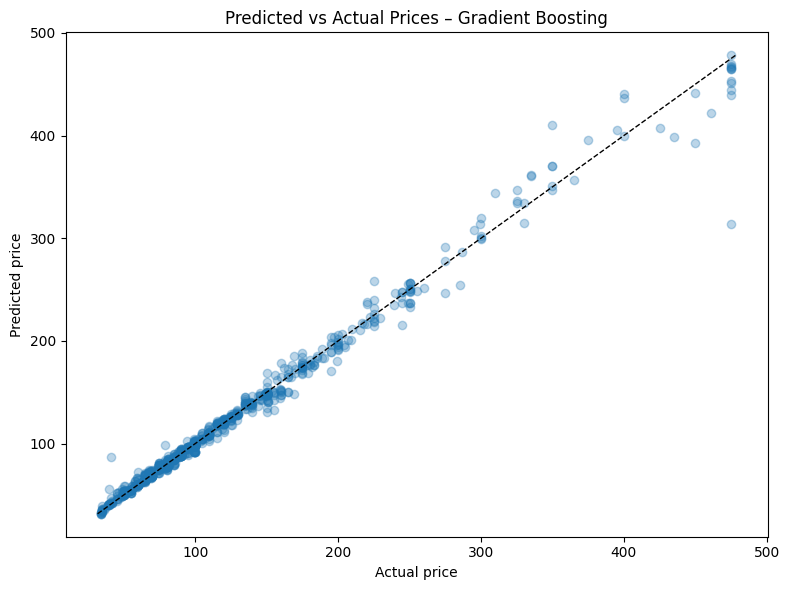

In [10]:

# Scatter plot: predicted vs. actual prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title(f'Predicted vs Actual Prices – {best_model_name}')
# Diagonal line
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.tight_layout()
plt.show()


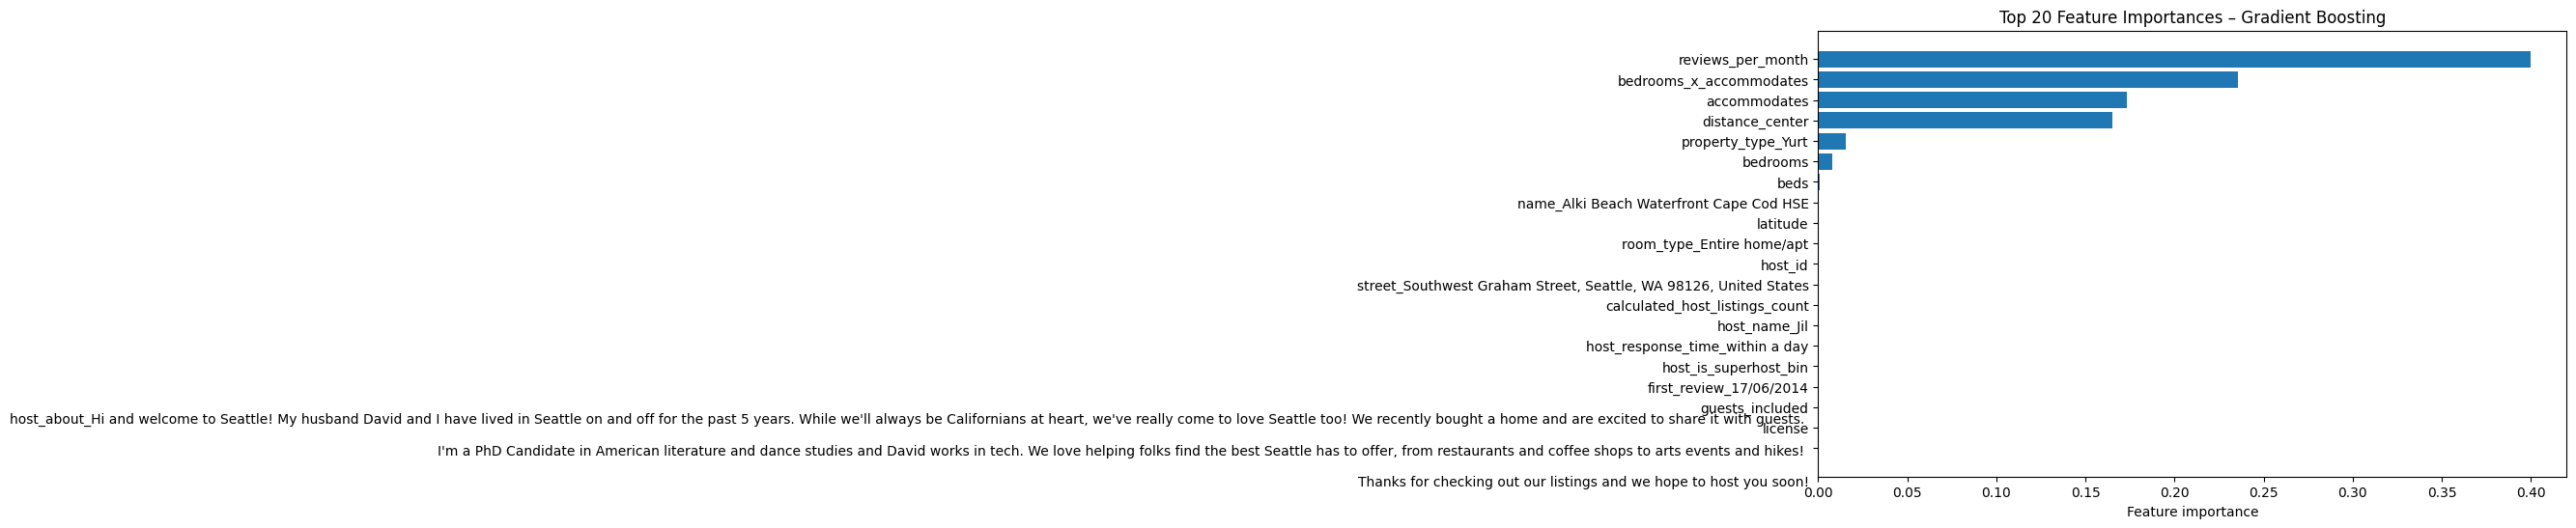

In [11]:

# Extract and plot feature importances if the best model is tree-based and exposes feature_importances_
try:
    # Fit a pipeline on the full training data (if not already fitted)
    if not hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
        raise AttributeError
    # Get feature names after one-hot encoding
    feature_names_num = numeric_features
    # Get names from one-hot encoder
    ohe = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    ohe_feature_names = ohe.get_feature_names_out(categorical_features)
    all_feature_names = list(feature_names_num) + list(ohe_feature_names)

    importances = best_pipeline.named_steps['model'].feature_importances_
    # Select top 20 features
    top_n = 20
    indices = np.argsort(importances)[-top_n:][::-1]
    top_features = [all_feature_names[i] for i in indices]
    top_importances = importances[indices]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features))[::-1], top_importances, align='center')
    plt.yticks(range(len(top_features))[::-1], top_features)
    plt.xlabel('Feature importance')
    plt.title(f'Top {top_n} Feature Importances – {best_model_name}')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Feature importances not available for the selected model:', e)


## Conclusion & Next Steps

In this project we built an end-to-end pipeline to predict Airbnb listing prices, starting from raw data and ending with a cross-validated, tested regression model. After cleaning the data, clipping extreme price outliers (1st–99th percentiles), and engineering domain-specific features, we compared several models: Dummy, Linear Regression, Ridge, Random Forest, Gradient Boosting, XGBoost, and LightGBM.

Model performance was evaluated with 3-fold cross-validation using MAE, RMSE, and R². Among all candidates, **Gradient Boosting** achieved the best trade-off between bias and variance, with a cross-validated RMSE of roughly **7.7** and **R² ≈ 0.99**. When retrained on the full training set and evaluated on a held-out test set, the final model reached:

- **Test MAE:** ≈ **4.39**
- **Test RMSE:** ≈ **9.62**
- **Test R²:** ≈ **0.987**

This means the model explains about **98–99%** of the variance in prices on unseen data, which is extremely strong performance for this dataset.

### Key takeaways

- **Feature engineering is crucial:** interaction features such as `bedrooms_x_accommodates`, ratios like `bed_ratio` and `bath_to_bed_ratio`, review-based metrics, host activity (`host_years_active`), and a simple location proxy (`distance_center`) significantly improved predictive power.
- **Robust handling of outliers stabilizes training:** clipping price at the 1st and 99th percentiles reduces the influence of rare luxury or mispriced listings and leads to more stable, generalizable models.
- **Gradient boosting methods work best for this problem:** while Linear and Ridge Regression already perform well, tree-based boosting models (Gradient Boosting, XGBoost, LightGBM) capture non-linear interactions and deliver substantially lower error.
- **The evaluation pipeline is reusable:** the same preprocessing + model pipeline, cross-validation setup, and comparison table can easily be applied to new datasets or extended with additional models.

### Possible next steps

- **Hyperparameter optimization:** apply Bayesian optimization or Optuna to further tune Gradient Boosting, XGBoost, and LightGBM.
- **Richer location features:** add distances to landmarks (city center, transport hubs, points of interest) or cluster neighborhoods to capture finer-grained spatial patterns.
- **Temporal patterns:** include booking dates, seasonality, and day-of-week effects to model dynamic pricing.
- **Interpretability:** use tools such as partial dependence plots or SHAP values to better understand how each feature influences the predicted price.
- **Deployment:** export the trained pipeline and wrap it in an API or simple web app so that users can input a listing’s characteristics and obtain a price suggestion in real time.
